Welcome to the final project of Deep Learning for Robot Perception, University of Michigan. This project proposes a perception system involving object detection and depth estimation to localize cutting points for grape bunches. The idea is to come up with a vision system capable of allowing robots to perceive grape stems and motion plan to grasp them.

Run some imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

import json

Google drive stuff, ignore for local.

In [2]:
# %load_ext autoreload
# %autoreload 2

# from google.colab import drive
# drive.mount("/content/drive", True)

# import os
# import sys

# path = '/content/drive/My Drive/grape_net'
# sys.path.append(path)

Test methods

In [2]:
from grape_net import hello_grape_net
from helpers import hello_helpers

hello_grape_net()
hello_helpers()

hello grape_net!
hello helpers!


Load the dataset and dataloader

In [3]:
from grape_net import GrapeNet
from grape_net import GrapeDataset
from torch.utils.data import DataLoader

#DATASET HERE
img_folder = 'grape_stem_data/grape_dataset/img'
label_folder = 'grape_stem_data/grape_dataset/ann'
grape_dataset = GrapeDataset(img_folder, label_folder)

print(f'Dataset loaded: {grape_dataset.__len__()} images and labels\n')

Loaded 300 images from folder grape_stem_data/grape_dataset/img
Loaded 20 labels from folder grape_stem_data/grape_dataset/ann
Dataset loaded: 20 images and labels



In [4]:
#DATALOADER
batch_size = 1
def collate_fn(batch):
    return tuple(zip(*batch))  

train_loader = DataLoader(grape_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f'DataLoader is ready with {len(train_loader)} batches')

DataLoader is ready with 20 batches


Training code

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def plot_bboxes(image_tensor, bboxes_tensor):
    
    image = image_tensor.permute(1,2,0)
    plt.imshow(image)
    
    for bbox in bboxes_tensor:
        xmin, ymin, xmax, ymax = bbox
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    
    plt.axis('off')
    plt.show()
    
def calculate_loss(outputs, verbose=False):
    loss_classifier = outputs['loss_classifier']
    loss_box_reg = outputs['loss_box_reg']
    loss_objectness = outputs['loss_objectness']
    loss_rpn_box_reg = outputs['loss_rpn_box_reg']

    # Add all the losses together
    total_loss = loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg

    if verbose:
        print(f'classifier loss: {loss_classifier:.4f}   box reg loss: {loss_box_reg:.4f}   objectness loss: {loss_objectness:.4f}   rpn loss: {loss_rpn_box_reg:.4f}   total loss: {total_loss:.4f}')

    return total_loss


def train(model, train_loader, optimizer, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    rpn_loss_history = []
    box_loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, targets in train_loader:
            
            images = list(image.to(torch.float32) for image in images)
            targets = [t for t in targets]
            
            no_bbox = False
            for t in targets:
                if t['boxes'].shape[0] == 0:
                    no_bbox = True

            if no_bbox:
                continue
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = calculate_loss(loss_dict, verbose=True)
            
            # if len(rpn_loss_history) > 3 and (abs(rpn_loss_history[-1] - loss_dict['loss_rpn_box_reg']) > 2 or abs(box_loss_history[-1] - loss_dict['loss_box_reg']) > 200):
            # if len(rpn_loss_history) > 3 and (abs(box_loss_history[-1] - loss_dict['loss_box_reg']) > 200):
            #     print('Bad loss, discarding..')
            #     continue

            if loss > 700:
                print(f'Bad loss, discarding..')
                continue
            
            loss.backward()
            
            optimizer.step()

            running_loss += loss.item() * images[0].size(0)

            rpn_loss_history.append(loss_dict['loss_rpn_box_reg'])
            box_loss_history.append(loss_dict['loss_box_reg'])

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Average epoch loss: {epoch_loss:.4f}\n')



In [9]:
import torchvision.models.detection.faster_rcnn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torchvision.models.detection.roi_heads


model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
num_classes = 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=1e-6)

train(model, train_loader, optimizer, num_epochs=10)

classifier loss: 0.0000   box reg loss: 1137.4263   objectness loss: 9.5963   rpn loss: 61.4256   total loss: 1208.4481
Bad loss, discarding..
classifier loss: 0.0000   box reg loss: 204.2041   objectness loss: 4.6754   rpn loss: 0.7846   total loss: 209.6641
classifier loss: 0.0000   box reg loss: 885.8781   objectness loss: 0.6718   rpn loss: 0.0655   total loss: 886.6154
Bad loss, discarding..
classifier loss: 0.0000   box reg loss: 377.1791   objectness loss: 1.4329   rpn loss: 0.0839   total loss: 378.6960
classifier loss: 0.0000   box reg loss: 1206.8744   objectness loss: 9.4839   rpn loss: 50.6223   total loss: 1266.9805
Bad loss, discarding..
classifier loss: 0.0000   box reg loss: 318.1935   objectness loss: 0.6615   rpn loss: 0.0290   total loss: 318.8840
classifier loss: 0.0000   box reg loss: 471.6931   objectness loss: 0.6454   rpn loss: 0.0472   total loss: 472.3857
classifier loss: 0.0000   box reg loss: 274.0472   objectness loss: 0.8044   rpn loss: 0.0524   total loss

In [7]:
torch.save(model.state_dict(), 'grapejuice_model1.pth')

Example usage

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.utils.data import Dataset

# Load the saved model
model.load_state_dict(torch.load('grapejuice_model1.pth'))
model.eval()

input_image = Image.open('/Users/adibalaji/Desktop/grape_juice/stem_detection/grape_stem_data/grape_dataset/img/CFR_1626.jpg')
transform = transforms.Compose([
    transforms.ToTensor(),
])
input_image = transform(input_image).unsqueeze(0)

with torch.no_grad():
    out = model(input_image)

print(out)


NameError: name 'model' is not defined

Define StemMasking masking dataset to train MaskRCNN for stem detection

In [38]:
import cv2
from PIL import Image
import os
from torch.utils.data import Dataset
import base64
import zlib
import json

class StemMaskDataset(Dataset):
  def __init__(self, img_folder, ann_folder):
    self.img_folder = img_folder
    self.ann_folder = ann_folder

    self.anns = []
    self.images = []

    for file in os.listdir(img_folder):
      img = Image.open(os.path.join(img_folder,file)).convert('RGB')
      self.images.append(img)

      json_file = file + '.json'
      with open(os.path.join(ann_folder, json_file), 'r') as f:
        json_file = json.load(f)
        self.anns.append(json_file)

    print(f'Loaded {len(self.images)} images and {len(self.anns)} anns.')

  def __len__(self):
     return len(self.images)
  
  def base64_to_mask(self, s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask
  
  def __getitem__(self, idx):
    img = self.images[idx]
    img = np.array(img)
    img = (img - img.min()) / np.max([img.max() - img.min(), 1])
    img = np.moveaxis(img, -1, 0)
    img = torch.as_tensor(img, dtype=torch.float32)  

    json_file = self.anns[idx]
    image_size = (json_file['size']['height'], json_file['size']['width'])

    listofboxes = []
    listofmasks = []
    objs = json_file['objects']
    num_objs = len(objs)
    for obj in objs:
      full_mask = torch.zeros(image_size, dtype=torch.uint8)
      encoded_data = obj['bitmap']['data']
      mask = self.base64_to_mask(encoded_data)
      mask = torch.as_tensor(mask, dtype=torch.uint8)
      ox, oy = obj['bitmap']['origin']
      full_mask[oy : oy + mask.shape[0], ox : ox + mask.shape[1]] = mask
      listofmasks.append(full_mask)

      box = [ox, oy, ox + mask.shape[1], oy + mask.shape[0]]
      box = torch.as_tensor(box, dtype=torch.float32)
      listofboxes.append(box)

    masks = torch.stack(listofmasks)
    boxes = torch.stack(listofboxes)
    labels = torch.ones((num_objs,), dtype=torch.int64)
    image_id = torch.tensor([idx])

    targets = {
      "boxes": boxes,
      "labels": labels,
      "masks": masks,
      "image_id": image_id
    }
    
    return img, targets



Dataset example

Loaded 15 images and 15 anns.


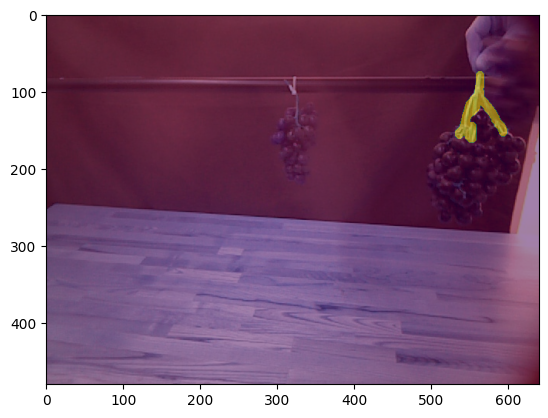

In [42]:
import matplotlib.pyplot as plt

img_folder_path = '/Users/adibalaji/Desktop/grape_juice/stem_detection/lab_grapes/grapes1_images/img'
ann_folder_path = '/Users/adibalaji/Desktop/grape_juice/stem_detection/lab_grapes/grapes1_images/ann'

dataset = StemMaskDataset(img_folder_path, ann_folder_path)

img, targets = dataset.__getitem__(1)

plt.imshow(img.permute(1,2,0).numpy())
plt.imshow(targets['masks'][1], alpha = 0.5)
plt.show()